# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

/home/ddallo/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 53 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000007
[3]:  Bus 1 Device 31 Dynapse1DevKit serial_number 00000020
[4]:  Bus 1 Device 25 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [311]:
chip = 2
core_e1 = 0
core_e2 = 1
core_i = 2

duration = 2

neuron_ids_E1 = np.arange(11,19)
neuron_ids_E2 = neuron_ids_E1 + neuron_ids_E1.size
neuron_ids_I1 = [3]
neuron_ids_I2 = [4]

# init a network generator
net = network.DynapseNetworkGenerator()

neurons_E1 = net.get_neurons(chip, core_e1, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e2, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)

net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=8)
# coupling
net.add_connections_all_to_all(neurons_I1, neurons_I2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2, neurons_I1, network.SYNAPSE_GABA_B)

dynapse.monitor_neuron_network(neurons_E1, neurons_E2, neurons_I1, neurons_I2)

model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [317]:
# set params
parameters.set_all_default_params(model)

# try to get each oscillator at 2 Hz
parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip, core_e1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e1)

parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip, core_e2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e2)

parameters.set_param(model, parameters.AMPA_WEIGHT, (5,70), chip, core_i)

parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_i)
parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,40), chip, core_i)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_i)

2400000000.0

In [315]:
dynapse.start_graph()

* to increase e1 firing rate, increase core_e1 DC input
* if e1 fires periodically but doesn't burst - increase e1 AMPA weight
* Same for e2


* decrease core_i AMPA weight to increase burst width, and increase it if the inhibitory neurons aren't spiking
* increasing the pulse width decreases the firing rate of the oscillator - can increase DC input to compensate...


* sometimes takes a while for it to settle into antiphase
* pulse width can be brittle with low values - reducing fine value by one can cause a big jump - here it's better to use a pulse width slightly above half

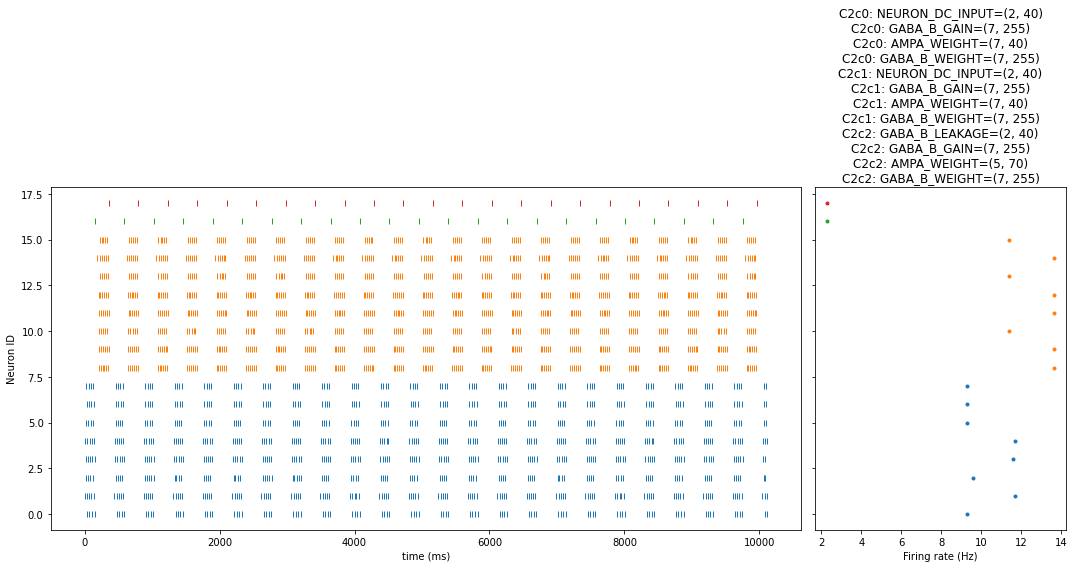

E1 firing rate: 2.2907 Hz
E2 firing rate: 2.2907 Hz
phase diff = -171.4209659018887 deg


In [318]:
spikes = dynapse.run_simulation(10)

plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,8))

I1_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[2])
I2_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[3])
T1 = np.mean(np.diff(I1_spikes[:,0]))
T2 = np.mean(np.diff(I2_spikes[:,0]))
print(f'E1 firing rate: {1000/T1:.4f} Hz')
print(f'E2 firing rate: {1000/T2:.4f} Hz')
print(f'phase diff = {np.mean(I1_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]-I2_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]) / (T1+T2)*2 * 360} deg')

### Testing for weird memory bug

In [115]:
default_param_map = parameters.get_default_params().param_map
config = model.get_configuration()

for chip in range(4):
		for core in range(4):
			for param_name, param in config.chips[chip].cores[core].parameter_group.param_map.items():
				if default_param_map[param_name].coarse_value != param.coarse_value or default_param_map[param_name].fine_value != param.fine_value:
					print(f'{param_name}: {(param.coarse_value,param.fine_value)} vs. {(default_param_map[param_name].coarse_value,default_param_map[param_name].fine_value)}')

NPDPII_THR_S_P: (7, 80) vs. (4, 80)
PS_WEIGHT_EXC_F_N: (5, 40) vs. (0, 0)
PS_WEIGHT_EXC_S_N: (5, 50) vs. (0, 0)
PS_WEIGHT_INH_S_N: (7, 200) vs. (0, 0)
PS_WEIGHT_EXC_F_N: (5, 30) vs. (0, 0)
PS_WEIGHT_INH_S_N: (6, 80) vs. (0, 0)
